# Trabalho Prático 2
## Júlia Fonseca de Sena - 2018054508

In [1]:
#Video: https://learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/
from platform import python_version
print('Python:', python_version())
import OpenGL
print('OpenGL:', OpenGL.__version__)
import cv2
print('OpenCV:', cv2.__version__)
import PIL
print('PIL:', PIL.__version__)
import numpy as np
print('Numpy:', np.__version__)
import matplotlib
import matplotlib.pyplot as plt
print('Matplotlib:', matplotlib.__version__)
import pygame

Python: 3.8.3
OpenGL: 3.1.1a1
OpenCV: 4.4.0
PIL: 7.2.0
Numpy: 1.18.5
Matplotlib: 3.3.4
pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## Carregando alvo

In [2]:
nome_alvo = 'alvo.jpg'
alvo = cv2.imread(nome_alvo,0)

### Binarizando o alvo

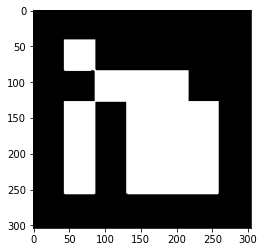

In [3]:
_, alvo = cv2.threshold(alvo, 80, 255, cv2.THRESH_BINARY)
plt.imshow(alvo, cmap = 'gray')
plt.show()

### Pegando diferentes ângulos do alvo

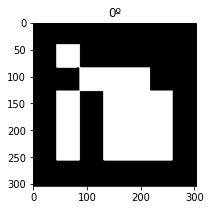

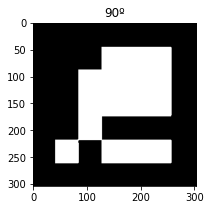

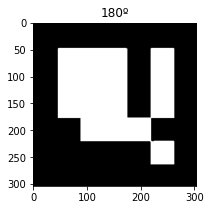

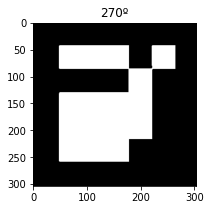

In [4]:
alvo_ang = []
for ang in [0, 90, 180, 270]:
  alvo_novo = cv2.getRotationMatrix2D((alvo.shape[1]/2, alvo.shape[0]/2), ang, 1)
  alvo_ang.append(cv2.warpAffine(alvo, alvo_novo, (alvo.shape[0], alvo.shape[1])))

plt.figure(figsize = (3,3))
plt.imshow(alvo_ang[0], cmap='gray')
plt.title('0º')
plt.show()

plt.figure(figsize = (3,3))
plt.imshow(alvo_ang[1], cmap='gray')
plt.title('90º')
plt.show()

plt.figure(figsize = (3,3))
plt.imshow(alvo_ang[2], cmap='gray')
plt.title('180º')
plt.show()

plt.figure(figsize = (3,3))
plt.imshow(alvo_ang[3], cmap='gray')
plt.title('270º')
plt.show()

alvo_coord = []
alvo_coord.append(np.array([[1,1,1], [1,-1,1], [-1,-1,1], [-1,1,1]]))
alvo_coord.append(np.array([[-1,-1,1], [-1,1,1], [1,1,1], [1,-1,1]]))
alvo_coord.append(np.array([[1,-1,1], [-1,-1,1], [-1,1,1], [1,1,1]]))
alvo_coord.append(np.array([[-1,1,1], [1,1,1], [1,-1,1], [-1,-1,1]]))

## Carregando vídeo e pegando frames

In [5]:
nome_video = 'entrada.mp4'
video = cv2.VideoCapture(nome_video)

frames = []
while(video.isOpened()):
    ret, frame = video.read()
    if ret is True:
        frames.append(frame)
    else:
        break

video.release()
len(frames)

1100

## Testando em um frame
### Aplicando Canny

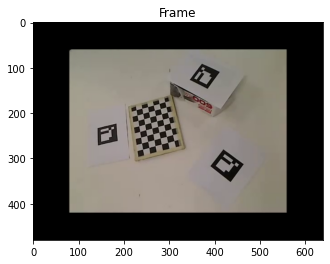

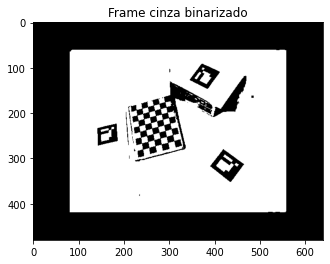

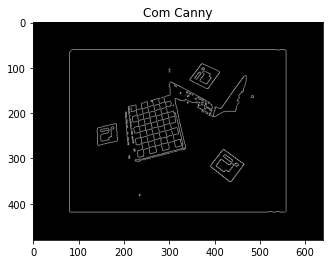

In [6]:
def aplicar_canny(frame):
    canny = cv2.Canny(frame,60,100)
    return canny

plt.imshow(cv2.cvtColor(frames[7], cv2.COLOR_BGR2RGB))
plt.title('Frame')
plt.show()

cinza = cv2.cvtColor(frames[7], cv2.COLOR_BGR2GRAY)
_, cinza_b = cv2.threshold(cinza, 127, 255, cv2.THRESH_BINARY)

plt.imshow(cv2.cvtColor(cinza_b, cv2.COLOR_BGR2RGB))
plt.title('Frame cinza binarizado')
plt.show()

canny_frame = aplicar_canny(cinza_b)

plt.imshow(canny_frame,cmap = 'gray')
plt.title('Com Canny')
plt.show()

### Achando quadriláteros

In [7]:
def poligonos_4_vertices(canny):
    contornos, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    quad = []
    
    for p in contornos:
        perimetro = cv2.arcLength(p, True)
        poligono = cv2.approxPolyDP(p, 0.02*perimetro, True)
        if len(poligono) == 4 and cv2.isContourConvex(poligono):
            quad.append(poligono)
    return quad

quadrilateros = poligonos_4_vertices(canny_frame)
quadrilateros

[array([[[419, 280]],
 
        [[391, 318]],
 
        [[437, 351]],
 
        [[465, 312]]], dtype=int32),
 array([[[183, 223]],
 
        [[142, 233]],
 
        [[143, 271]],
 
        [[186, 261]]], dtype=int32),
 array([[[340, 176]],
 
        [[340, 178]],
 
        [[342, 178]],
 
        [[342, 176]]], dtype=int32),
 array([[[324, 155]],
 
        [[324, 157]],
 
        [[326, 157]],
 
        [[326, 155]]], dtype=int32),
 array([[[373,  91]],
 
        [[346, 128]],
 
        [[386, 146]],
 
        [[411, 109]]], dtype=int32)]

### Aplicando homografia nos quadriláteros

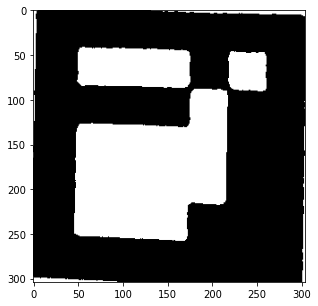

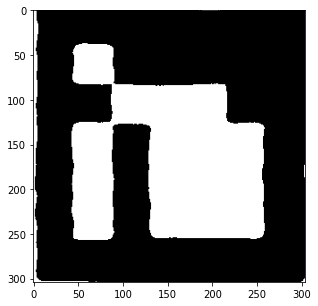

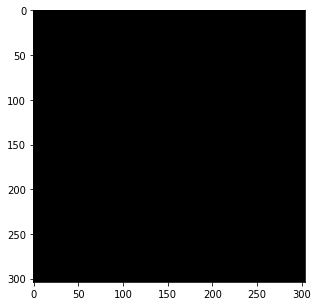

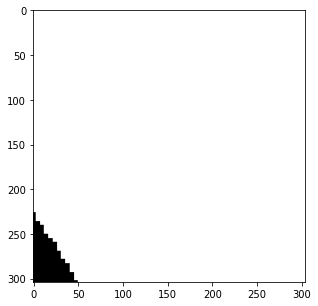

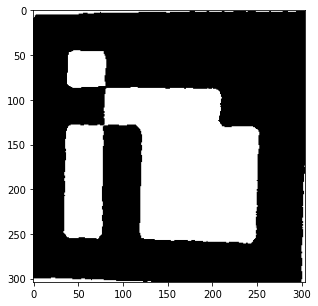

In [8]:
def homografia(poligonos, cinza):
    altura, largura = alvo.shape
    dst = np.float32([[0,0], [0, altura], [largura, altura], [largura, 0]])
    
    warps = []
    for p in poligonos:
        homografia, _ = cv2.findHomography(np.float32(p), dst, cv2.RANSAC)
        perspectiva = cv2.warpPerspective(np.float32(cinza), homografia, (altura, largura))
        _, perspectiva_b = cv2.threshold(perspectiva, 80, 255, cv2.THRESH_BINARY)
        warps.append(perspectiva_b)
    
    return warps

novas_perspectivas = homografia(quadrilateros, cinza)
for polig in novas_perspectivas:
    plt.figure(figsize = (5,5))
    plt.imshow(polig, cmap='gray')
    plt.show()

### Selecionando alvos no frame

In [9]:
def detecta_alvos(perspectivas, originais, alvos):
    angulos = []
    alvos_img = []
    for i in range(len(perspectivas)):
        min_erro = np.sum(np.abs(perspectivas[i] - alvos[0])) / (perspectivas[i].size)
        min_position = 0
        
        for j in range(1, len(alvos)):
            aux = np.sum(np.abs(perspectivas[i] - alvos[j])) / (perspectivas[i].size)
            if aux < min_erro:
                min_erro = aux
                min_position = j
        
        ang = -1
        if min_erro <= 50:
            ang = i
        
        if ang != -1:
            angulos.append(ang)
            alvos_img.append(originais[i])
            
    return angulos, alvos_img
    
angs, poligs = detecta_alvos(novas_perspectivas, quadrilateros, alvo_ang)
len(poligs)

3

### Destacando no frame

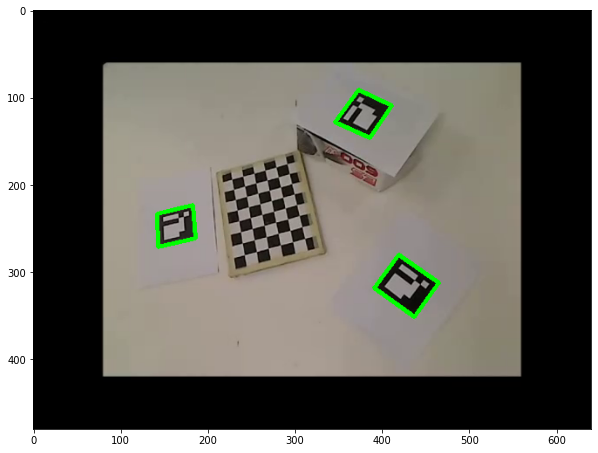

In [10]:
def contorna_frame(frame, img_alvos):
    frame_novo = np.copy(frame)
    for alvo in img_alvos:
        frame_novo = cv2.polylines(frame_novo, [alvo], True, (0, 255, 0), 3)
    return frame_novo

desenhado = contorna_frame(frames[7], poligs)
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(desenhado, cv2.COLOR_BGR2RGB))
plt.show()

## Processando todos os frames

In [11]:
def encontrar_alvos(frame):
    cinza = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, cinza_b = cv2.threshold(cinza, 127, 255, cv2.THRESH_BINARY)
    
    canny_frame = aplicar_canny(cinza_b)
    
    quadrilateros = poligonos_4_vertices(canny_frame)
    
    novas_perspectivas = homografia(quadrilateros, cinza)
    
    angs, poligs = detecta_alvos(novas_perspectivas, quadrilateros, alvo_ang)
    
    desenhado = contorna_frame(frame, poligs)
    
    return desenhado, poligs, angs

In [12]:
def processar_video():
    novos_frames = []
    poligs = []
    angs = []
    for f in frames:
        novo_f, polig, ang = encontrar_alvos(f)
        novos_frames.append(novo_f)
        poligs.append(polig)
        angs.append(ang)

    for frame in novos_frames:
        cv2.imshow('Video', frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()
    
    return novos_frames, poligs, angs
    
frames_desenhados, alvos, angulos = processar_video()

## Renderização

In [13]:
from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *
from objloader import *

### Criando matriz de parâmetros intrínsecos

In [14]:
def matriz_intrins():
    f = [556.03562, 554.37431]
    p = [333.31317, 235.73889]
    distorcao = np.array([0.06580, 0.10956, -0.00040, 0.00037, 0.00000])
    
    m = np.array([[f[0], 0.0, p[0]], [0.0, f[1], p[1]], [0.0, 0.0, 1.0]])
    
    return m, distorcao

matriz_intrins()

(array([[556.03562,   0.     , 333.31317],
        [  0.     , 554.37431, 235.73889],
        [  0.     ,   0.     ,   1.     ]]),
 array([ 0.0658 ,  0.10956, -0.0004 ,  0.00037,  0.     ]))

### Estimando pose

In [15]:
def estima_pose(alvo, angulo):
    dst = alvo_coord[angulo]
    intrinsecos, distorcao = matriz_intrins()
    
    _, rvec, tvec = cv2.solvePnP(np.float32(dst), np.float32(alvo), intrinsecos, distorcao)
    rotacao, _ = cv2.Rodrigues(rvec)
    
    m = np.array([
        [rotacao[0][0], rotacao[0][1], rotacao[0][2], tvec[0]],
        [rotacao[1][0], rotacao[1][1], rotacao[1][2], -tvec[1]],
        [rotacao[2][0], rotacao[2][1], rotacao[2][2], -tvec[2]],
        [0.0, 0.0, 0.0, 1.0]
    ])

    m = np.transpose(m)
    return m

estima_pose(poligs[0], angs[0])

array([[-0.794132707951217, -0.5567260129527948, 0.24374041245503714,
        0.0],
       [0.5971342783305805, -0.6401538449276392, 0.48335670934308644,
        0.0],
       [-0.11306589142921875, 0.5293951277883512, 0.8408072923501984,
        0.0],
       [array([3.5879538]), array([-2.37247508]), array([-19.6418533]),
        1.0]], dtype=object)

In [16]:
def initOpenGL(dimensions, matrix):

    (width, height) = dimensions
    
    glClearColor(0.0, 0.0, 0.0, 0.0)
    glClearDepth(1.0)

    glEnable(GL_DEPTH_TEST)

    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
 
    #fovy = 2 * np.arctan(0.5 * height / matrix[1][1]) * 180 / 3.14159265
    #aspect = (width * matrix[1][1])/(height * matrix[0][0])
    fovy = 45
    aspect = (width)/(height)
    gluPerspective(fovy, aspect, 0.1, 100.0)

In [17]:
frame_index = 0

def object3D(obj, num):
    if frame_index < len(frames):
        alvos_frame = alvos[frame_index]
        angs_frame = angulos[frame_index]
        #_, posicoes, orientacoes = frames_processados[frame_index]
        for i in range(len(alvos_frame)):
            print('entrou aqui')
            gl.glMatrixMode(gl.GL_MODELVIEW)
            gl.glLoadIdentity()
            gl.glPushMatrix()
            pose = estima_pose(alvos_frame[i], angs_frame[i])
            gl.glLoadMatrixf(pose)
            gl.glCallList(obj.gl_list)
            gl.glPopMatrix()
    i = i + 1
    print(i)

In [18]:
def displayCallback():
    gl.glMatrixMode(gl.GL_MODELVIEW)
    gl.glLoadIdentity()
    
    gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)

    obj = OBJ("Pikachu.obj", swapyz=True)

    gl.glEnable(gl.GL_TEXTURE_2D)

    object3D(obj, 0) 
        
    glut.glutSwapBuffers()

In [19]:
def idleCallback():
    glut.glutPostRedisplay()

In [ ]:
def renderizacao():
    dimensions = (640, 480)
    glutInit()
    glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE)
    glutSetOption(GLUT_ACTION_ON_WINDOW_CLOSE, GLUT_ACTION_CONTINUE_EXECUTION)
    glutInitWindowSize(*dimensions)
    window = glutCreateWindow(b'Realidade Aumentada [codigo esqueleto]')
    
    initOpenGL(dimensions, matriz_intrins)
    
    glutDisplayFunc(displayCallback)
    glutIdleFunc(idleCallback)
    
    glutMainLoop()

renderizacao()